In [7]:
from HMM import QHMM

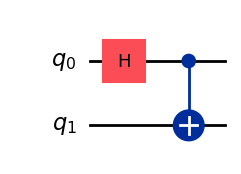

In [8]:
from qiskit import QuantumCircuit

# 2 qubits = 4 hidden states
initial_state = QuantumCircuit(2, name='Initial_State')
initial_state.h(0)
initial_state.cx(0,1)
initial_state.draw('mpl')

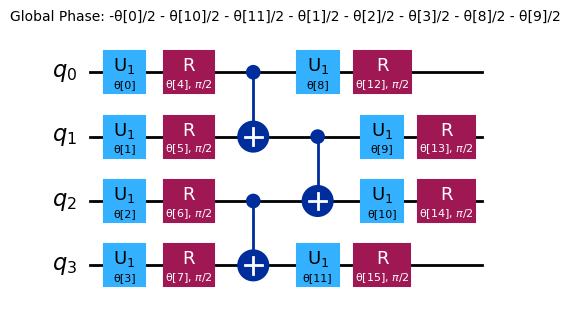

In [9]:
from qiskit.circuit.library import real_amplitudes, efficient_su2

#ansatz = real_amplitudes(3, reps=1)
ansatz = efficient_su2(4, reps=1, entanglement='pairwise', su2_gates=['rz','ry'])
ansatz.decompose(reps=1).draw('mpl')

In [10]:
import numpy as np

# Generating and starting parameters
num_parameters = ansatz.num_parameters

#theta_gen = [np.random.uniform(2*np.pi,  6* np.pi) for _ in range(num_parameters)]
#theta_0 = [4*np.pi for _ in range(num_parameters)]

theta_gen = [np.random.uniform(-2*np.pi,  2*np.pi) for _ in range(num_parameters)]
theta_0 = [0 for _ in range(num_parameters)]

In [11]:
from HMM.utils.qhmm_utils import aer_simulator_result_getter

simulator_rg = aer_simulator_result_getter()

In [12]:
model = QHMM(result_getter=simulator_rg,
             initial_state=initial_state,
             ansatz=ansatz,
             theta=theta_gen)

circuit = model.construct_circuit(num_time_steps=2)

In [28]:
from qiskit import ClassicalRegister, QuantumRegister

def construct_kraus_circuit(model,
                          num_time_steps,
                          save_state=False) -> QuantumCircuit:
        if model.theta is None:
            raise ValueError('theta must be set in order to construct a circuit')

        circ = QuantumCircuit()
        hidden_register = QuantumRegister(model.hidden_qubits, 'Hidden')
        circ.add_register(hidden_register)
        observed_register = QuantumRegister(model.observed_qubits, 'Observed')
        circ.add_register(observed_register)

        circ.append(model.initial_state, hidden_register)

        for step in range(num_time_steps):
            circ.barrier()
            circ.append(model.ansatz, circ.qubits)
            #if save_state:
            #    circ.save_statevector(label='step_'+str(step))
            #else:
            #    creg = ClassicalRegister(model.observed_qubits, "step_"+str(step))
            #    circ.add_register(creg)
            #    circ.measure(observed_register, creg)
            #if not step == num_time_steps-1:
            #    circ.reset(observed_register)

        circ.assign_parameters(model.theta, inplace=True)

        return circ

circuit = construct_kraus_circuit(model=model, num_time_steps=2)

In [29]:
from qiskit.quantum_info import Kraus

kraus = Kraus(circuit)

In [36]:
print(kraus.data[0].shape)

(16, 16)
